In [3]:
## got help from JWarmenhoven

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.figsize'] = 8, 8
from IPython.display import Image

In [4]:
import pymc3 as pm
import random
import numpy as np
from scipy.stats import beta, binom, bernoulli
import pandas as pd
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from collections import Counter
from theano.tensor import eq
color = 'lightsteelblue'

# Chapter 10: Model Comparison and Hierarchical Modeling

There are many possible models for a given dataset. Model comparison essentially reallocates credibility across the models. Given a model m, the likelihood function for model m is $ p(y \vert \theta_m,m) $ and each model has probability $p(m)$. Bayes' rule now becomes

$$ p(\theta1, \theta_2, ... , m \vert D) = \frac{p(D \vert \theta_1, \theta_2,..., m)p(\theta_1, \theta_2,..., m)}{\sum_m \int d\theta_m p(D \vert \theta_1, \theta_2,..., m)p(\theta_1, \theta_2,..., m)}$$

$$ = \frac{\Pi_m p_m(D \vert \theta_m, m)p_m(\theta_m \vert m)p(m)}{\sum_m \int d\theta_m \Pi_m p_m(D \vert \theta_m, m)p_m(\theta_m \vert m)p(m)}$$

The posterior probability is then 
$$ p(m \vert D) = \frac{p(D \vert m)p(m)}{\sum_m p(D \vert m)p(m)} $$

where the probability given the model is 

$$ p(D \vert m) = \int d\theta_m p_m(D \vert \theta_m,m)p_m(\theta_m \vert m) $$

The relative posterior probability is 
$$ \frac{p(m = 0 \vert D)}{p(m = 1 \vert D)} = \frac{p(D \vert m = 0)p(m = 0) / \sum_m p(D \vert m)p(m)}{p(D \vert m = 1)p(m = 1) / \sum_m p(D \vert m)p(m)} $$

$$ = \frac{p(D \vert m = 0)p(m = 0)}{p(D \vert m = 1)p(m = 1)} $$

Another way to say this is that the posterior odds is the Bayes' factor times the prior odds. Typically, if the ratio of the bayes' factor is greater than 3, there is substantial evidence for model 0 and if the factor is less than 1/3, then there is substantial evidence for model 1.

## Example: Two Factories of Coins

Suppose we have one coin that could be made in one of two factories, one with a heads bias and one with a tails bias. The tail-biased factory (model 0) produces coins with a mode of $\omega_1 = 0.25$ and a concentration of $\kappa = 12$. Thus, $\theta \sim$ beta$(\theta \vert 3.5,8.5)$. The head-biased factory (model 1) produces coins with a mode of 0.75 and a concentration of 12. Thus, $\theta \sim$ beta$(\theta \vert 8.5,3.5)$. The coin is flipped 9 times of which there are 6 heads.

An analytical analysis shows that the Bayes' factor tails to head ratio is 0.213, thus favoring the heads-biased factory. Given the data, the posterior belief of the tail biased model is 17.6% and the belief for the head biased model is 82.4%. 

### Hierarchical MCMC computation - One value of $\theta$

In [53]:
observed = [0,0,0,1,1,1,1,1,1]
priors = np.asarray([.5, .5])

with pm.Model() as model:
    
    # defining models
    models = pm.Categorical('model', priors )
    
    # defining parameters
    kappa = 12
    omega = pm.math.switch(eq(models, 0), .25, .75)
    
    # prior
    theta = pm.Beta('theta', omega*(kappa - 2)+1, (1-omega)*(kappa - 2)+1)
    
    # likelihood
    y = pm.Bernoulli('y', theta, observed=observed)   
    
    with model:
        trace = pm.sample(15000, init=None, tune=1500, nuts_kwargs={'target_accept': 0.9}, progressbar = False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model]
>NUTS: [theta_logodds__]
The number of effective samples is smaller than 25% for some parameters.


In [54]:
df = pm.trace_to_dataframe(trace)
df = df.set_index('model')
burnin=300

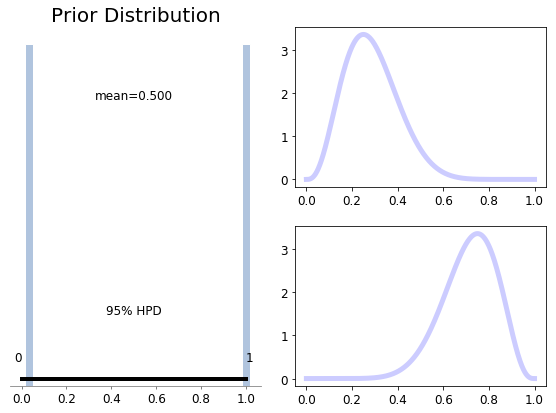

In [55]:
from scipy.stats import beta
kappa = 12

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2)

ax = plt.subplot(gs[0:2,0])
pm.plot_posterior(np.array([0,1]), ax=ax, color=color)
ax.set_title('Prior Distribution')

ax0 = plt.subplot(gs[0,1])
omega = 0.25
x = np.linspace(0,1,1001)
ax0.plot(x, beta.pdf(x, omega*(kappa)+1, (1-omega)*(kappa)+1), 'b-', lw=5, alpha=0.2)

ax1 = plt.subplot(gs[1,1])
omega = 0.75
x = np.linspace(0,1,1001)
ax1.plot(x, beta.pdf(x, omega*(kappa)+1, (1-omega)*(kappa)+1), 'b-', lw=5, alpha=0.2)

plt.tight_layout()
plt.show()

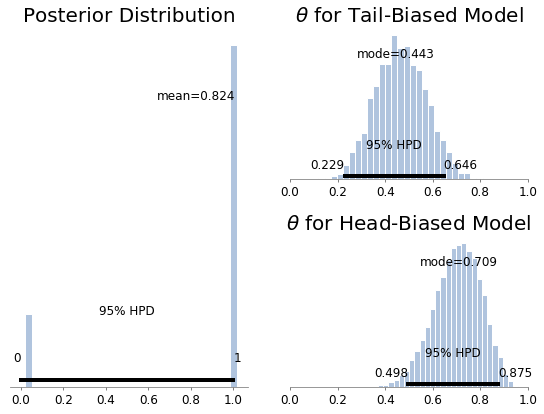

In [56]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2)

ax = plt.subplot(gs[0:2,0])
pm.plot_posterior(np.array(df.index), ax=ax, color=color)
ax.set_title('Posterior Distribution')

ax0 = plt.subplot(gs[0,1])
pm.plot_posterior(np.array(df[df.index == 0]).ravel()[burnin:],ax=ax0, color=color, point_estimate = 'mode');
ax0.set_xlim([0,1])
ax0.set_title(r'$\theta$ for Tail-Biased Model')

ax1 = plt.subplot(gs[1,1])
pm.plot_posterior(np.array(df[df.index == 1]).ravel()[burnin:],ax=ax1, color=color, point_estimate = 'mode');
ax1.set_xlim([0,1])
ax1.set_title(r'$\theta$ for Head-Biased Model')

plt.tight_layout()
plt.show()

In [57]:
counts = Counter(df.index)
print("Posterior Belief of Tail Biased Factory =", counts[0] / (counts[0] + counts[1]) )
print("Posterior Belief of Head Biased Factory =", counts[1] / (counts[0] + counts[1]) )

Posterior Belief of Tail Biased Factory = 0.17596666666666666
Posterior Belief of Head Biased Factory = 0.8240333333333333


### Hierarchical MCMC computation - Two value of $\theta$

It is more convenient and generalizable to use different priors for each model as shown below. 

In [112]:
observed = [0,0,0,1,1,1,1,1,1]
priors = np.asarray([.5, .5])

with pm.Model() as model:
    models = pm.Categorical('model', priors)
    
    # defining parameters for the model 0
    omega_0 = .25
    kappa_0 = 12
    
    # defining parameters for the model 1
    omega_1 = .75
    kappa_1 = 12
    
    # priors
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0 - 2)+1, (1-omega_0)*(kappa_0 - 2)+1)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1 - 2)+1, (1-omega_1)*(kappa_1 - 2)+1)
    theta = pm.math.switch(eq(models, 0), theta_0, theta_1)
    
    y = pm.Bernoulli('y', theta, observed=observed)   
    
    with model:
        trace = pm.sample(15000, init=None, progressbar = False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model]
>NUTS: [theta_1_logodds__, theta_0_logodds__]


### Hierarchical MCMC Computation with Psuedopriors

The problem with the above method is that the chains from the MCMC chains tend to be highly autocorrelated. During each step of the chain generation, one $\theta$ is given a value while the other $\theta$ is sampled from the prior with no constraints. When the next step is chosen, the sampler will stay with the current model because the other $\theta$ is chosen from the prior and is probably not a good description of the data.

The solution around this is to use psuedopriors. For each unconstrained parameter, the goal is keep to parameter is a posterior credible range by having a prior that is similar to the posterior (psuedoprior). When the parameter is constrained, the original, true prior is used. This is a 2 step process. 

1. Run the bayesian analysis with no psuedopriors (psuedopriors = true prior). 
2. Rerun the analysis but the psuedopriors set to estimated posterior. 

Consider a new experiment two 2 models. The tail biased model (model 0) has $\omega_0 = 0.1$ with $\kappa_0 = 20$ and the head biased model (model 1) has $\omega_1 = 0.9$ with $\kappa_1 = 20$. The coin is flipped 30 times of which 17 were heads. 

First is the analysis by setting the psuedopriors to the true prior.

In [262]:
observed = np. array([0] * 13 + [1] * 17)
priors = np.asarray([.5, .5])

with pm.Model() as model:
    models = pm.Categorical('model', priors)
    
    # defining parameters for the model 0
    kappa_0_true = kappa_0_pseudo = 20
    kappa_0 = pm.math.switch(eq(models, 0), kappa_0_true, kappa_0_pseudo)
    omega_0_true = omega_0_pseudo = .10
    omega_0 = pm.math.switch(eq(models, 0), omega_0_true, omega_0_pseudo)
    
    # defining parameters for the model 1  
    kappa_1_true = kappa_1_pseudo = 20
    kappa_1 = pm.math.switch(eq(models, 1), kappa_1_true, kappa_1_pseudo)
    omega_1_true = omega_1_pseudo = .90
    omega_1 = pm.math.switch(eq(models, 1), omega_1_true, omega_1_pseudo)
    
    # priors
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0 - 2)+1, (1-omega_0)*(kappa_0 - 2)+1)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1 - 2)+1, (1-omega_1)*(kappa_1 - 2)+1)
    theta = pm.math.switch(eq(models, 0), theta_0, theta_1)
    
    y = pm.Bernoulli('y', theta, observed=observed)
    
    with model:
        trace = pm.sample(30000, init=None, tune=3000, nuts_kwargs={'target_accept': 0.9}, progressbar = False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model]
>NUTS: [theta_1_logodds__, theta_0_logodds__]
The acceptance probability does not match the target. It is 0.798676017123, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


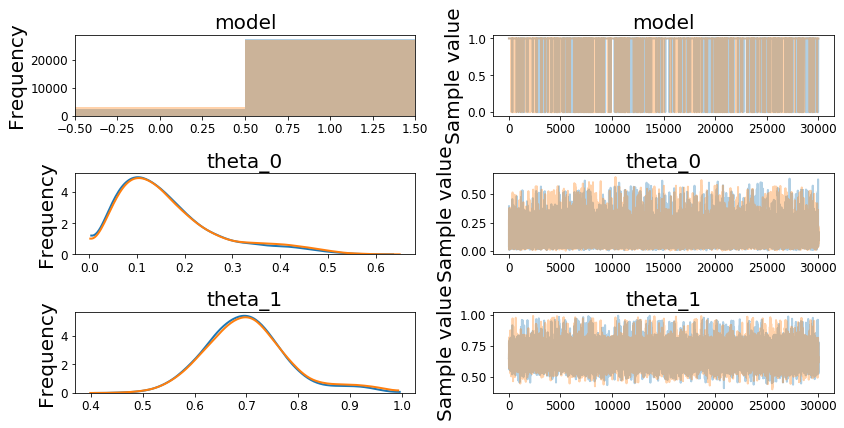

In [263]:
pm.traceplot(trace);

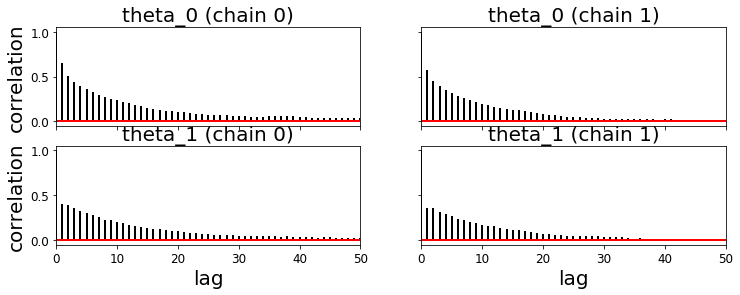

In [136]:
pm.plots.autocorrplot(trace, varnames = ['theta_0','theta_1'],max_lag = 50);

In [128]:
df = pm.trace_to_dataframe(trace)
df = df.set_index('model')
burnin=300

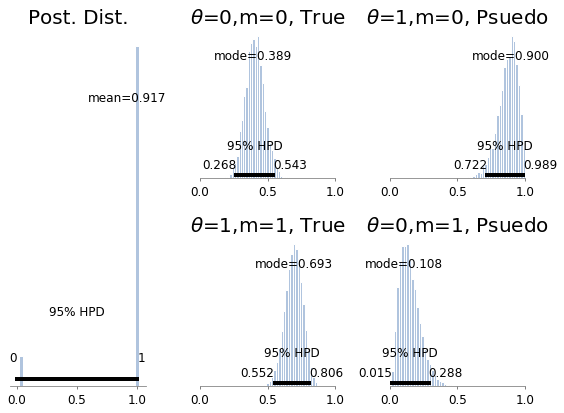

In [132]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3)

ax = plt.subplot(gs[0:2,0])
pm.plot_posterior(np.array(df.index), ax=ax, color=color)
ax.set_title('Post. Dist.')

ax0 = plt.subplot(gs[0,1])
pm.plot_posterior(np.array(df[df.index == 0].theta_0).ravel()[burnin:],ax=ax0, color=color, point_estimate = 'mode');
ax0.set_xlim([0,1])
ax0.set_title(r'$\theta$=0,m=0, True')

ax1 = plt.subplot(gs[0,2])
pm.plot_posterior(np.array(df[df.index == 0].theta_1).ravel()[burnin:],ax=ax1, color=color, point_estimate = 'mode');
ax1.set_xlim([0,1])
ax1.set_title(r'$\theta$=1,m=0, Psuedo')

ax2 = plt.subplot(gs[1,1])
pm.plot_posterior(np.array(df[df.index == 1].theta_1).ravel()[burnin:],ax=ax2, color=color, point_estimate = 'mode');
ax2.set_xlim([0,1])
ax2.set_title(r'$\theta$=1,m=1, True')

ax3 = plt.subplot(gs[1,2])
pm.plot_posterior(np.array(df[df.index == 1].theta_0).ravel()[burnin:],ax=ax3, color=color, point_estimate = 'mode');
ax3.set_xlim([0,1])
ax3.set_title(r'$\theta$=0,m=1, Psuedo')

plt.tight_layout()
plt.show()

The above graphs clarify that the psuedopriors for $\theta$ are not doing a good job of representing the data but instead are very similar to the prior of 0.1 and 0.9. There is also a large autocorrelation in all of the chains.

Below, we do the rerun of the analysis using the estimated posterior. $\omega$ is chosen by using the modes from the posteriors above. $\kappa$ increases as a function of the number of data points. With 30 flips and a prior of 20, the new $\kappa$ is 50

In [264]:
observed = np. array([0] * 13 + [1] * 17)
priors = np.asarray([.5, .5])

with pm.Model() as model:
    models = pm.Categorical('model', priors)
    
    # defining parameters for the model 0
    kappa_0_true = 20
    kappa_0_pseudo = 50
    kappa_0 = pm.math.switch(eq(models, 0), kappa_0_true, kappa_0_pseudo)
    omega_0_true = 0.10
    omega_0_pseudo = 0.389
    omega_0 = pm.math.switch(eq(models, 0), omega_0_true, omega_0_pseudo)
    
    # defining parameters for the model 1  
    kappa_1_true = 20
    kappa_1_pseudo = 50
    kappa_1 = pm.math.switch(eq(models, 1), kappa_1_true, kappa_1_pseudo)
    omega_1_true = 0.90
    omega_1_pseudo = 0.693
    omega_1 = pm.math.switch(eq(models, 1), omega_1_true, omega_1_pseudo)
    
    # priors
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0 - 2)+1, (1-omega_0)*(kappa_0 - 2)+1)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1 - 2)+1, (1-omega_1)*(kappa_1 - 2)+1)
    theta = pm.math.switch(eq(models, 0), theta_0, theta_1)
    
    y = pm.Bernoulli('y', theta, observed=observed)
    
    with model:
        trace = pm.sample(30000, init=None, tune=3000, nuts_kwargs={'target_accept': 0.9}, progressbar = False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model]
>NUTS: [theta_1_logodds__, theta_0_logodds__]


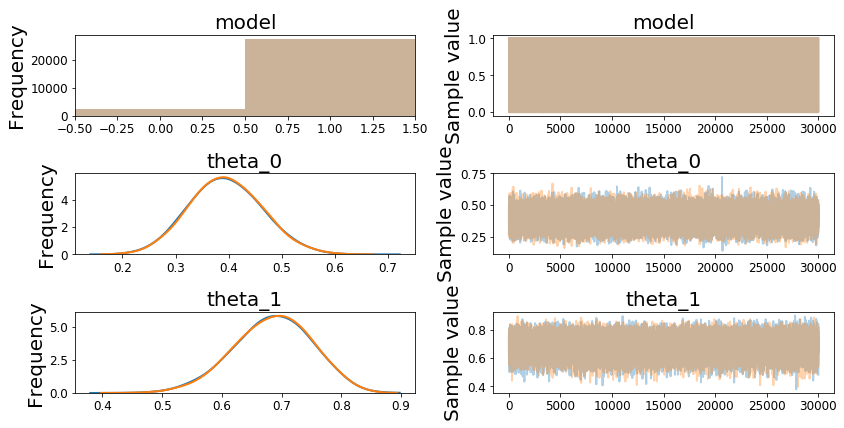

In [265]:
pm.traceplot(trace);

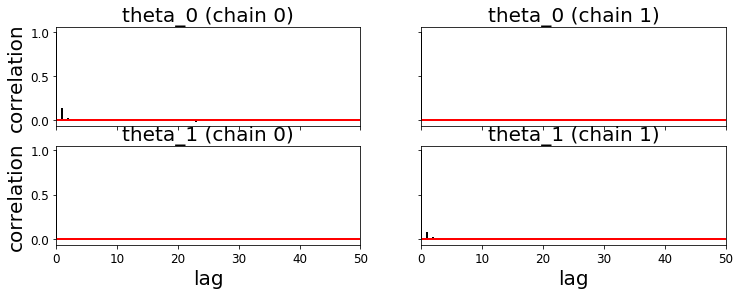

In [266]:
pm.plots.autocorrplot(trace, varnames = ['theta_0','theta_1'],max_lag = 50);

In [174]:
df = pm.trace_to_dataframe(trace)
df = df.set_index('model')
burnin=300

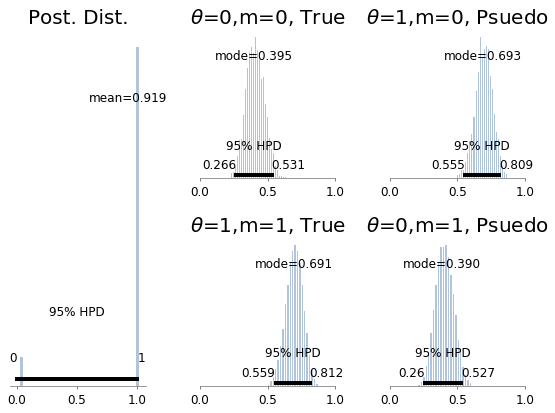

In [175]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3)

ax = plt.subplot(gs[0:2,0])
pm.plot_posterior(np.array(df.index), ax=ax, color=color)
ax.set_title('Post. Dist.')

ax0 = plt.subplot(gs[0,1])
pm.plot_posterior(np.array(df[df.index == 0].theta_0).ravel()[burnin:],ax=ax0, color=color, point_estimate = 'mode');
ax0.set_xlim([0,1])
ax0.set_title(r'$\theta$=0,m=0, True')

ax1 = plt.subplot(gs[0,2])
pm.plot_posterior(np.array(df[df.index == 0].theta_1).ravel()[burnin:],ax=ax1, color=color, point_estimate = 'mode');
ax1.set_xlim([0,1])
ax1.set_title(r'$\theta$=1,m=0, Psuedo')

ax2 = plt.subplot(gs[1,1])
pm.plot_posterior(np.array(df[df.index == 1].theta_1).ravel()[burnin:],ax=ax2, color=color, point_estimate = 'mode');
ax2.set_xlim([0,1])
ax2.set_title(r'$\theta$=1,m=1, True')

ax3 = plt.subplot(gs[1,2])
pm.plot_posterior(np.array(df[df.index == 1].theta_0).ravel()[burnin:],ax=ax3, color=color, point_estimate = 'mode');
ax3.set_xlim([0,1])
ax3.set_title(r'$\theta$=0,m=1, Psuedo')

plt.tight_layout()
plt.show()

The psuedopriors now match the actual posteriors.

In the above examples, we use 50-50 priors. Because of this, model 0 is not sampled as much as model 1 in the chain generation. One way to get around this is to have more samples. Another option is to is to change the odds. The posterior probability for 50-50 priors can still be calculated using other odds. 

$$ \frac{p(m=0|D)}{p(m=1|D)}= BF\frac{p(m = 0)}{p(m = 1)} $$

Solving for BF gets

$$ BF = \frac{p(m=0|D)}{p(m=1|D)} \frac{p(m = 1)}{p(m = 0)} $$

In the case of 50-50 odds:

$$ BF = \frac{p(m=0|D)}{p(m=1|D)} $$

### Sensitivty to Priors

The prior distribution greatly affects the final posterior values. One easy method to choosing a good prior is to choose an uninformative prior, or one that favors all possible values. Another method is to use a subset of the data to inform all possible priors. This forces all of the priors to be close to a reasonable prior.

# Chapter 10: Exercises 

## Exercise 10.1

Consider the scenario in which there were two coin factories, one of which was tail-biased and the other head-biased. Suppose we flip a coin that we know is from one of the two factories but we do not know which factory, and the prior probabilities of the factories are 50/50. The results show z = 7 heads in N = 10 flips.

A. If $\omega_0$ = 0.25, $\omega_1$ = 0.75, and $\kappa$ = 6, what are the posterior probabilities of the factories?

Answer: 0.3333

In [179]:
beta = lambda a,b: math.gamma(a)*math.gamma(b)/math.gamma(a+b)

def likelihood(z,N,a,b, beta):
    return math.exp(math.log(beta(z+a,N-z+b))-math.log(beta(a,b)))

omega_0 = 0.25
omega_1 = 0.75
kappa = 6
z = 7
N = 10
prior0 = 0.5
prior1 = 0.5

a0 = omega_0 * (kappa - 2) + 1
b0 = (1 - omega_0) * (kappa - 2) + 1
a1 = omega_1 * (kappa - 2) + 1
b1 = (1 - omega_1) * (kappa - 2) + 1

lhood0 = likelihood(z,N,a0,b0, beta)
lhood1 = likelihood(z,N,a1,b1, beta)

print("Posterior Probability =", lhood0/lhood1)

Posterior Probability = 0.33333333333333354


B. If $\omega_0$ = 0.25, $\omega_1$ = 0.75, and $\kappa$ = 202, what are the posterior probabilities of the factories?

Answer: Because of an overflow error, I set $\kappa$ = 160. Posterior probability is 0.017.

In [197]:
beta = lambda a,b: math.gamma(a)*math.gamma(b)/math.gamma(a+b)

def likelihood(z,N,a,b, beta):
    return math.exp(math.log(beta(z+a,N-z+b))-math.log(beta(a,b)))

omega_0 = 0.25
omega_1 = 0.75
kappa = 160
z = 7
N = 10
prior0 = 0.5
prior1 = 0.5

a0 = omega_0 * (kappa - 2) + 1
b0 = (1 - omega_0) * (kappa - 2) + 1
a1 = omega_1 * (kappa - 2) + 1
b1 = (1 - omega_1) * (kappa - 2) + 1

lhood0 = likelihood(z,N,a0,b0, beta)
lhood1 = likelihood(z,N,a1,b1, beta)

print("Posterior Probability =", lhood0/lhood1)

Posterior Probability = 0.017325967441042842


C. Why are the posterior probabilities so different in parts A and B, even though the modes of the factories are the same?

Answer: Because the concentration is so much higher, it is very likely that the coin came from the head biased factory.

## Exercise 10.2

A. Reproduce figure 10.4

Answer: Done above already.

B. Make a histogram of the $\theta$ values collapsed across both models.


In [198]:
observed = [0,0,0,1,1,1,1,1,1]
priors = np.asarray([.5, .5])

with pm.Model() as model:
    
    # defining models
    models = pm.Categorical('model', priors )
    
    # defining parameters
    kappa = 12
    omega = pm.math.switch(eq(models, 0), .25, .75)
    
    # prior
    theta = pm.Beta('theta', omega*(kappa - 2)+1, (1-omega)*(kappa - 2)+1)
    
    # likelihood
    y = pm.Bernoulli('y', theta, observed=observed)   
    
    with model:
        trace = pm.sample(15000, init=None, tune=1500, nuts_kwargs={'target_accept': 0.9}, progressbar = False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model]
>NUTS: [theta_logodds__]
The number of effective samples is smaller than 25% for some parameters.


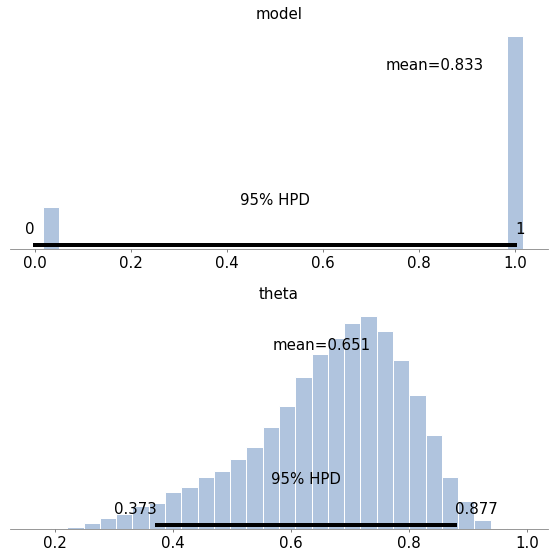

In [228]:
# fig = plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(2)
pm.plot_posterior(trace, ax = ax, color=color);

FIX FIX FIX - doesnt answer question, need to convert answer to account for 70-30 odds

C. Use the script to reproduce the previous exercise. That is, change the data to z = 7 heads in N = 10, and run the script once with $\kappa$ = 6 and once with $\kappa$ = 202. Do the MCMC results match the analytical results?

Answer: With such a strong concentration, the steps in the chain generation was not changing models. To fix this, I changed $\kappa$ to 50 and changed the model odds to 70-30. 

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model]
>NUTS: [theta_logodds__]


Posterior Belief of Tail Biased Factory = 0.25456666666666666
Posterior Belief of Head Biased Factory = 0.7454333333333333


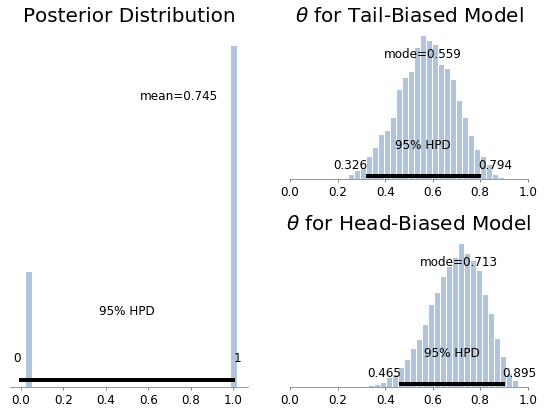

In [256]:
observed = [0,0,0,1,1,1,1,1,1,1]
priors = np.asarray([.5, .5])

with pm.Model() as model:
    
    # defining models
    models = pm.Categorical('model', priors )
    
    # defining parameters
    kappa = 6
    omega = pm.math.switch(eq(models, 0), .25, .75)
    
    # prior
    theta = pm.Beta('theta', omega*(kappa - 2)+1, (1-omega)*(kappa - 2)+1)
    
    # likelihood
    y = pm.Bernoulli('y', theta, observed=observed)   
    
    with model:
        trace = pm.sample(15000, init=None, tune=1500, nuts_kwargs={'target_accept': 0.9}, progressbar = False)
        
df = pm.trace_to_dataframe(trace)
df = df.set_index('model')
burnin=300

counts = Counter(df.index)
print("Posterior Belief of Tail Biased Factory =", counts[0] / (counts[0] + counts[1]) )
print("Posterior Belief of Head Biased Factory =", counts[1] / (counts[0] + counts[1]) )

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2)

ax = plt.subplot(gs[0:2,0])
pm.plot_posterior(np.array(df.index), ax=ax, color=color)
ax.set_title('Posterior Distribution')

ax0 = plt.subplot(gs[0,1])
pm.plot_posterior(np.array(df[df.index == 0]).ravel()[burnin:],ax=ax0, color=color, point_estimate = 'mode');
ax0.set_xlim([0,1])
ax0.set_title(r'$\theta$ for Tail-Biased Model')

ax1 = plt.subplot(gs[1,1])
pm.plot_posterior(np.array(df[df.index == 1]).ravel()[burnin:],ax=ax1, color=color, point_estimate = 'mode');
ax1.set_xlim([0,1])
ax1.set_title(r'$\theta$ for Head-Biased Model')

plt.tight_layout()
plt.show()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model]
>NUTS: [theta_logodds__]
The acceptance probability does not match the target. It is 0.215521881342, but should be close to 0.9. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Posterior Belief of Tail Biased Factory = 0.21606666666666666
Posterior Belief of Head Biased Factory = 0.7839333333333334


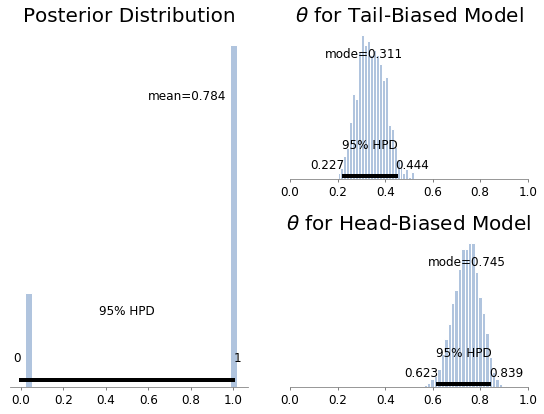

In [259]:
observed = [0,0,0,1,1,1,1,1,1,1]
priors = np.asarray([.7, .3])

with pm.Model() as model:
    
    # defining models
    models = pm.Categorical('model', priors )
    
    # defining parameters
    kappa = 50
    omega = pm.math.switch(eq(models, 0), .25, .75)
    
    # prior
    theta = pm.Beta('theta', omega*(kappa - 2)+1, (1-omega)*(kappa - 2)+1)
    
    # likelihood
    y = pm.Bernoulli('y', theta, observed=observed)   
    
    with model:
        trace = pm.sample(15000, init=None, tune=1000, nuts_kwargs={'target_accept': 0.9}, progressbar = False)
        
df = pm.trace_to_dataframe(trace)
df = df.set_index('model')
burnin=300

counts = Counter(df.index)
print("Posterior Belief of Tail Biased Factory =", counts[0] / (counts[0] + counts[1]) )
print("Posterior Belief of Head Biased Factory =", counts[1] / (counts[0] + counts[1]) )

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2)

ax = plt.subplot(gs[0:2,0])
pm.plot_posterior(np.array(df.index), ax=ax, color=color)
ax.set_title('Posterior Distribution')

ax0 = plt.subplot(gs[0,1])
pm.plot_posterior(np.array(df[df.index == 0]).ravel()[burnin:],ax=ax0, color=color, point_estimate = 'mode');
ax0.set_xlim([0,1])
ax0.set_title(r'$\theta$ for Tail-Biased Model')

ax1 = plt.subplot(gs[1,1])
pm.plot_posterior(np.array(df[df.index == 1]).ravel()[burnin:],ax=ax1, color=color, point_estimate = 'mode');
ax1.set_xlim([0,1])
ax1.set_title(r'$\theta$ for Head-Biased Model')

plt.tight_layout()
plt.show()

## Exercise 10.3

A. Recreate Figures 10.5 and 10.6. Include the graphical output of the chain diagnostics on the model index.

Answer: Already done above.

B. Change the psuedopriors to a broad distribution of $\omega$ = 0.5 and $\kappa$ = 2.1

Answer: The autocorrelation is very high, suggesting that the chains are very correlated. The posterior from the psuedoprior includes the true prior.

In [267]:
observed = np. array([0] * 13 + [1] * 17)
priors = np.asarray([.5, .5])

with pm.Model() as model:
    models = pm.Categorical('model', priors)
    
    # defining parameters for the model 0
    kappa_0_true = 20
    kappa_0_pseudo = 2.1
    kappa_0 = pm.math.switch(eq(models, 0), kappa_0_true, kappa_0_pseudo)
    omega_0_true = 0.10
    omega_0_pseudo = 0.5
    omega_0 = pm.math.switch(eq(models, 0), omega_0_true, omega_0_pseudo)
    
    # defining parameters for the model 1  
    kappa_1_true = 20
    kappa_1_pseudo = 2.1
    kappa_1 = pm.math.switch(eq(models, 1), kappa_1_true, kappa_1_pseudo)
    omega_1_true = 0.90
    omega_1_pseudo = 0.5
    omega_1 = pm.math.switch(eq(models, 1), omega_1_true, omega_1_pseudo)
    
    # priors
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0 - 2)+1, (1-omega_0)*(kappa_0 - 2)+1)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1 - 2)+1, (1-omega_1)*(kappa_1 - 2)+1)
    theta = pm.math.switch(eq(models, 0), theta_0, theta_1)
    
    y = pm.Bernoulli('y', theta, observed=observed)
    
    with model:
        trace = pm.sample(30000, init=None, tune=3000, nuts_kwargs={'target_accept': 0.9}, progressbar = False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model]
>NUTS: [theta_1_logodds__, theta_0_logodds__]
The acceptance probability does not match the target. It is 0.771701136051, but should be close to 0.9. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.729962809126, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


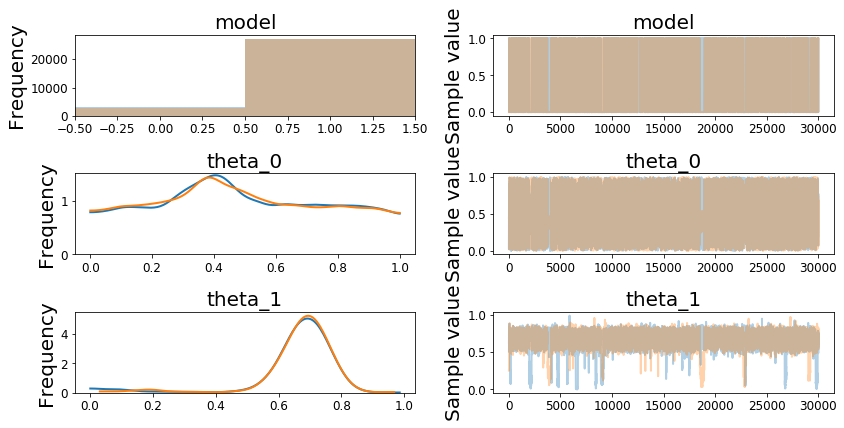

In [268]:
pm.traceplot(trace);

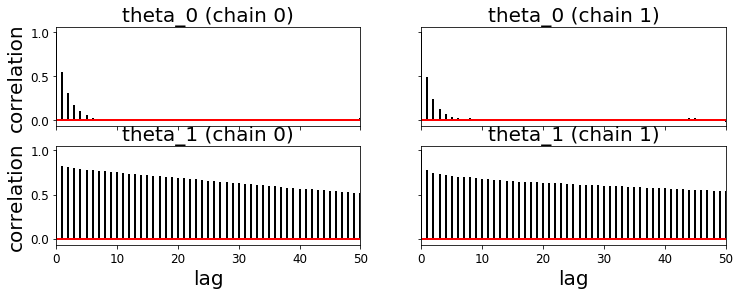

In [269]:
pm.plots.autocorrplot(trace, varnames = ['theta_0','theta_1'],max_lag = 50);

In [270]:
df = pm.trace_to_dataframe(trace)
df = df.set_index('model')
burnin=300

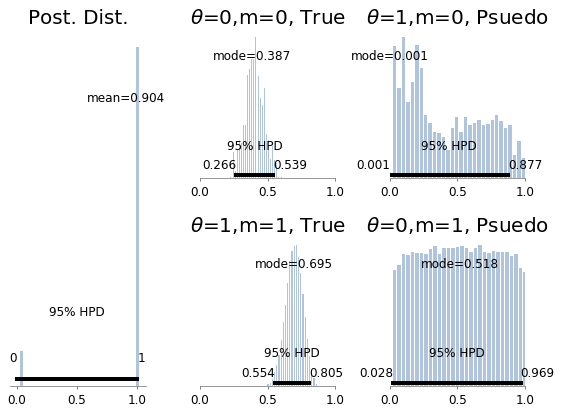

In [271]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3)

ax = plt.subplot(gs[0:2,0])
pm.plot_posterior(np.array(df.index), ax=ax, color=color)
ax.set_title('Post. Dist.')

ax0 = plt.subplot(gs[0,1])
pm.plot_posterior(np.array(df[df.index == 0].theta_0).ravel()[burnin:],ax=ax0, color=color, point_estimate = 'mode');
ax0.set_xlim([0,1])
ax0.set_title(r'$\theta$=0,m=0, True')

ax1 = plt.subplot(gs[0,2])
pm.plot_posterior(np.array(df[df.index == 0].theta_1).ravel()[burnin:],ax=ax1, color=color, point_estimate = 'mode');
ax1.set_xlim([0,1])
ax1.set_title(r'$\theta$=1,m=0, Psuedo')

ax2 = plt.subplot(gs[1,1])
pm.plot_posterior(np.array(df[df.index == 1].theta_1).ravel()[burnin:],ax=ax2, color=color, point_estimate = 'mode');
ax2.set_xlim([0,1])
ax2.set_title(r'$\theta$=1,m=1, True')

ax3 = plt.subplot(gs[1,2])
pm.plot_posterior(np.array(df[df.index == 1].theta_0).ravel()[burnin:],ax=ax3, color=color, point_estimate = 'mode');
ax3.set_xlim([0,1])
ax3.set_title(r'$\theta$=0,m=1, Psuedo')

plt.tight_layout()
plt.show()